In [13]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


groq_llm=ChatGroq(model="qwen-2.5-32b")

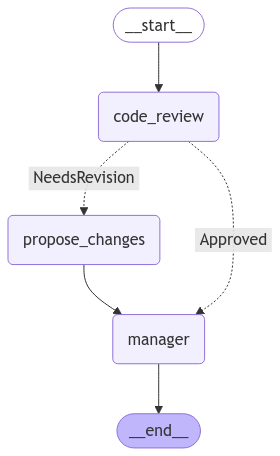


--- Execution 1: Code Approved Directly ---
[code_review] Analyzing code...
[code_review] Review outcome: Approved
[manager] The Manager receives the code for final approval.
[manager] Final code:
def foo():
    return 'hello world'
Final state: {'code_content': "def foo():\n    return 'hello world'", 'review_outcome': 'Approved'}

--- Execution 2: Code Needs Revision ---
[code_review] Analyzing code...
[code_review] Review outcome: NeedsRevision
[propose_changes] Proposing changes for the code...
[propose_changes] Revised code: The provided Python code snippet contains a function named `foo` which attempts to return a variable named `error`. However, unless `error` is defined somewhere in the code before this function is run or within the function itself, this will result in a `NameError` because `error` is not a built-in variable in Python and it is not recognized by default.

Here is the original code for reference:

```python
def foo():
    return error
```

To improve this code, 

In [21]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from IPython.display import Image, display
from typing import TypedDict

# ---------------------------------------------------------------------
# 1. Define the state class using TypedDict
# ---------------------------------------------------------------------
class CodeReviewState(TypedDict):
    """
    State that flows through the Code Review process.
    """
    code_content: str    # The code content to review
    review_outcome: str  # The review outcome: "Approved" or "NeedsRevision"


# ---------------------------------------------------------------------
# 2. Define classes to invoke your Gro LLM
# ---------------------------------------------------------------------
class LLMReview:
    """
    Uses your Gro LLM to analyze the code.
    """
    def analyze(self, code_content: str) -> str:
        prompt = (
            f"Analyze the following Python code:\n\n"
            f"{code_content}\n\n"
            "Respond only with 'Approved' if the code is correct or 'NeedsRevision' if changes are needed."
        )
        response = groq_llm.invoke(prompt)
        return response.content.strip()

class LLMPropose:
    """
    Uses your Gro LLM to propose changes to the code.
    """
    def propose(self, code_content: str) -> str:
        prompt = (
            f"Review the following Python code:\n\n"
            f"{code_content}\n\n"
            "Provide an improved version of the code with suggestions and necessary changes to correct it."
        )
        response = groq_llm.invoke(prompt)
        return response.content.strip()

# Instantiate the LLM classes
llm_review = LLMReview()
llm_propose = LLMPropose()


# ---------------------------------------------------------------------
# 3. Define the functions (nodes) of the workflow
# ---------------------------------------------------------------------
def code_review(state: CodeReviewState) -> CodeReviewState:
    """
    The Code Review LLM analyzes the code.
    It determines whether the code is good ("Approved") or needs revision ("NeedsRevision").
    """
    print("[code_review] Analyzing code...")
    outcome = llm_review.analyze(state["code_content"])
    state["review_outcome"] = outcome
    print(f"[code_review] Review outcome: {outcome}")
    return state

def propose_changes(state: CodeReviewState) -> CodeReviewState:
    """
    If the code needs revision, another LLM is invoked to propose changes.
    """
    print("[propose_changes] Proposing changes for the code...")
    revised = llm_propose.propose(state["code_content"])
    state["code_content"] = revised
    # We assume that after proposing changes, the code is approved.
    state["review_outcome"] = "Approved"
    print(f"[propose_changes] Revised code: {revised}")
    return state

def manager(state: CodeReviewState) -> CodeReviewState:
    """
    The Manager receives the code (already reviewed or reviewed and modified) and performs the final approval.
    """
    print("[manager] The Manager receives the code for final approval.")
    print(f"[manager] Final code:\n{state['code_content']}")
    # Additional logic for final approval could be added here.
    return state


# ---------------------------------------------------------------------
# 4. Build the StateGraph with nodes and transitions
# ---------------------------------------------------------------------
workflow = StateGraph(CodeReviewState)

# Add nodes to the graph
workflow.add_node("code_review", code_review)
workflow.add_node("propose_changes", propose_changes)
workflow.add_node("manager", manager)

# Connect nodes:
# START -> code_review
workflow.add_edge(START, "code_review")

# From code_review, depending on the review outcome, transition:
# - If "Approved": go directly to manager.
# - If "NeedsRevision": go to propose_changes.
workflow.add_conditional_edges(
    "code_review",
    lambda state: state["review_outcome"],
    {
        "Approved": "manager",
        "NeedsRevision": "propose_changes"
    }
)

# If changes have been proposed, go to manager
workflow.add_edge("propose_changes", "manager")

# End: manager -> END
workflow.add_edge("manager", END)

# Compile the workflow and (optionally) visualize the graph
chain = workflow.compile()
try:
    display(Image(chain.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Could not display the Mermaid diagram:", e)


# ---------------------------------------------------------------------
# 5. Example Execution
# ---------------------------------------------------------------------
if __name__ == "__main__":
    # Example 1: Code without an "error" (approved directly)
    initial_state: CodeReviewState = {
        "code_content": "def foo():\n    return 'hello world'",
        "review_outcome": ""
    }
    print("\n--- Execution 1: Code Approved Directly ---")
    print(chain)
    final_state = chain.invoke({"code_content": "def foo():\n    return 'hello world'"})
    print("Final state:", final_state)

    print("\n--- Execution 2: Code Needs Revision ---")
    final_state_error = chain.invoke({"code_content": "def foo():\n    return error"})
    print("Final state:", final_state_error)

